# Simple Multi AI Agent

In [1]:
import os 
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool 
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph,END 
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API_KEY'))


In [3]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver 

In [4]:
## Define the state 
class AgentState(MessagesState):
    next_agent:str # which agent should go next 

In [5]:
# create simple tools 
@tool 
def search_web(query:str)->str:
    """ 
    Search the web for information
    """
    search=TavilySearchResults(max_results=3)
    results=search.invoke(query)
    return results

@tool
def write_summary(content:str)-> str:
    """ 
    write a summary of the provided context.
    """
    # simple summary generation 
    summary=f'Summary of findings:\n\n{content[:500]}...'
    return summary


In [6]:
 # define agent functions (simple approach)
def researcher_agent(state:AgentState):
    """ 
    Researcher agent that searches for information 
    """
    messages =state['messages']

    # Add system message for contexxt 
    system_msg=SystemMessage(content="You are a research assistant. Use the serach_web tool to find information about the user's request")

    # call LLM with tools 
    researcher_llm=llm_open_ai.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)
    print(response)
    # return the response and route to writer 
    return {
        "messages":[response],
        "next_agent":"writer"
    }

In [7]:
# define write agent 
def writer_agent(state:AgentState):
    """ 
    writer agent that creates summaries
    """
    messages=state['messages']

    # Add system message 
    system_msg=SystemMessage(content='you are a technical writer. Review the conversation and create a clear, concise summary of the findings')

    # Simple completion without tools 
    response=llm_open_ai.invoke([system_msg]+messages)
    # print(messages)
    return {
        "messages":[response],
        "next_agent":"end"
    }



In [8]:
def execute_tools(state: AgentState):
    """ 
    Execute any pending tool calls 
    """
    messages=state['messages']
    last_messages=messages[-1]

    # Check if there are tool calls to execute 
    if hasattr(last_messages, "tool_calls") and last_messages.tool_calls:
        # create tool node and execute 
        tool_node=ToolNode([search_web, write_summary])
        response=tool_node.invoke(state)
        return response
    
    # No tools to execute 
    return state

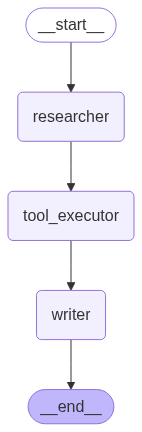

In [9]:
# build graph
workflow=StateGraph(AgentState)

# Add nodes 
workflow.add_node('researcher',researcher_agent)
workflow.add_node('writer',writer_agent)
workflow.add_node('tool_executor',ToolNode([search_web,write_summary]))

# Define flow 
workflow.set_entry_point('researcher')
workflow.add_edge('researcher','tool_executor')
workflow.add_edge('tool_executor','writer')
workflow.add_edge('writer',END)
final_workflow=workflow.compile()
final_workflow

In [10]:
response=final_workflow.invoke({'messages':"Research about the use case of agentic AI in business"})
print(response['messages'][-1].content)

content='' additional_kwargs={'tool_calls': [{'id': 'call_Kx0TgF8Vt6kE6rAAAvZaor0T', 'function': {'arguments': '{"query":"agentic AI use cases in business"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 74, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_e6529acef4', 'id': 'chatcmpl-BvStPGI1ZuKSJebuR48rUd5t0gjNz', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'saf

C:\Users\26amr\AppData\Local\Temp\ipykernel_2732\957222989.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search=TavilySearchResults(max_results=3)


Agentic AI is transforming business operations by autonomously analyzing environments, making decisions, and executing actions to meet specific objectives. Key use cases include:

1. **Customer Service Automation**:
   - Instant chatbot responses to inquiries.
   - Efficient ticket routing and multi-language support.
   - Enhancing knowledge base management and identifying upselling opportunities.

2. **Streamlining Enterprise Operations**:
   - Automating routine workflows, such as converting meeting notes into actionable tasks or triggering supply chain actions.
   - Driving efficiency in detail-oriented tasks, such as coding.

3. **Cybersecurity Enhancements**:
   - Real-time detection and mitigation of security and fraud threats.
   - Helping security teams predict and address evolving threats proactively.

4. **Industry-Specific Benefits**:
   - Optimizing processes in healthcare, financial services, and retail/e-commerce.

Adoption of agentic AI often leads to cost savings, effic

# Simple multi AI agent

In [11]:
import os 
from typing import TypedDict, Annotated, List, Literal 
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import AzureChatOpenAI 
from langchain_core.tools import tool 
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from langgraph.checkpoint.memory import MemorySaver 
from langchain_groq import ChatGroq 
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API'))

In [13]:
# define state
class AgentState(MessagesState):
    next_agent:str # which agent should go next

In [14]:
# create tool
@tool 
def search_web(query:str)-> str:
    """ 
    search the web for information 
    """
    search=TavilySearchResults(max_results=3)
    results=search.invoke(query)
    return results 

@tool
def write_summary(text:str)-> str:
    """ 
    write a summary of the provided context 
    """
    prompt=[
        SystemMessage(content='you are helpful summarization assistant'),
        {'role':'user','content':f'Summaraize the folloing content:\n\n{text}'}
    ]
    response=llm_open_ai.invoke(prompt)
    return response.content

In [15]:
# reearch agent 
def researcher_agent(state:AgentState):
    """
    Research agent that searches for information 
    """
    messages=state['messages']
    system_msg=SystemMessage(content='you are a research assistant. Use the search_web tool to find information ')

    researcher_llm=llm_open_ai.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)
    print(response)
    return {
        "messages":[response],
        "next_agent":"writer"
    }

In [16]:
# writer agent 
def writer_agent(state:AgentState):
    """ 
    writer agent that creats summary
    """
    messages=state['messages']
    system_msg=SystemMessage(content='you are a technical weiter, Review the summary and write a clear summary of the content')
    filtered_messages = []
    for msg in messages:
        # Keep all non-AI messages (e.g., System, Human)
        if not isinstance(msg, AIMessage):
            filtered_messages.append(msg)
        # Keep only AI messages that do not include tool_calls
        elif not getattr(msg, "tool_calls", None):
            filtered_messages.append(msg)
    print(f'message:',messages)
    print(f'filtered_messages:',filtered_messages)
    # simple completion without tools 
    response=llm_open_ai.invoke([system_msg]+filtered_messages)
    return {
        'messages':[response],
        'next_agent':'end'
    }

In [17]:
# def execute_tools(state:AgentState)

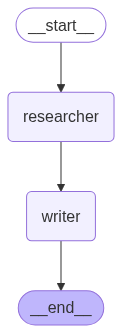

In [18]:
# build graph
workflow=StateGraph(AgentState)

# Add nodes 
workflow.add_node('researcher',researcher_agent)
workflow.add_node('writer',writer_agent)
# workflow.add_node('tool_executor',ToolNode([search_web,write_summary]))

# Define flow 
workflow.set_entry_point('researcher')
workflow.add_edge('researcher','writer')
# workflow.add_edge('tool_executor','writer')
workflow.add_edge('writer',END)
final_workflow=workflow.compile()
final_workflow

In [19]:
response=final_workflow.invoke({'messages':"Research about the use case of agentic AI in business"})
print(response['messages'][-1].content)

content='' additional_kwargs={'tool_calls': [{'id': 'call_CCXA3qbNwsf5lDQP0hVB20b4', 'function': {'arguments': '{"query":"use cases of agentic AI in business"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 69, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_e6529acef4', 'id': 'chatcmpl-BvStVzSjzX4WF0DGYTN5JrAcdJJig', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': '

In [20]:
response

{'messages': [HumanMessage(content='Research about the use case of agentic AI in business', additional_kwargs={}, response_metadata={}, id='aba1ff9c-79d1-40b7-819b-59672eca8e4c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CCXA3qbNwsf5lDQP0hVB20b4', 'function': {'arguments': '{"query":"use cases of agentic AI in business"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 69, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_e6529acef4', 'id': 'chatcmpl-BvStVzSjzX4WF0DGYTN5JrAcdJJig', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbrea